[20220924]

# 2. Model 7

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen5

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [6]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [8]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [11]:
%matplotlib inline

## Get Data

In [12]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen5_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [13]:
Xt.shape

(386396, 15, 3)

In [14]:
yt.shape

(386396, 1)

In [15]:
SEQ = Xt.shape[1]

In [18]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

## Model 1

In [19]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
mod_ts = Sequential()
mod_ts.add(LSTM(256, input_shape=(SEQ, 3), return_sequences=True))
mod_ts.add(LSTM(128, return_sequences=True))
mod_ts.add(LSTM(64))
mod_ts.add(Dense(32))
mod_ts.add(Dense(16))
mod_ts.add(Dense(8))
mod_ts.add(Dense(1))


In [24]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model7_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [25]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1812/1812 [==============================] - 28s 16ms/step - loss: 0.7300 - the_rmse: 0.8544 - the_mape: 142131.9531 - val_loss: 0.6758 - val_the_rmse: 0.8221 - val_the_mape: 121770.0859
Epoch 2/50
1812/1812 [==============================] - 28s 15ms/step - loss: 0.6113 - the_rmse: 0.7819 - the_mape: 160624.2188 - val_loss: 0.5773 - val_the_rmse: 0.7598 - val_the_mape: 187492.0156
Epoch 3/50
1812/1812 [==============================] - 27s 15ms/step - loss: 0.5623 - the_rmse: 0.7498 - the_mape: 152682.6250 - val_loss: 0.5540 - val_the_rmse: 0.7443 - val_the_mape: 129614.1172
Epoch 4/50
1812/1812 [==============================] - 28s 15ms/step - loss: 0.5495 - the_rmse: 0.7413 - the_mape: 140072.6562 - val_loss: 0.5373 - val_the_rmse: 0.7330 - val_the_mape: 160505.1094
Epoch 5/50
1812/1812 [==============================] - 27s 15ms/step - loss: 0.5364 - the_rmse: 0.7324 - the_mape: 135908.6094 - val_loss: 0.5330 - val_the_rmse: 0.7301 - val_the_mape: 156698.0469
Epoch 6/50

## Eval

<AxesSubplot:>

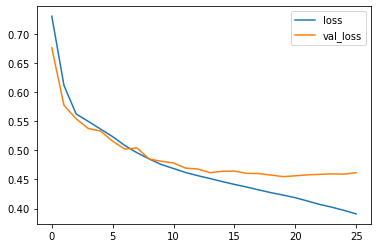

In [26]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [27]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model7_iter3.h5',compile=False)

In [28]:
model_load.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15, 256)           266240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [29]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [30]:
model_load.evaluate(x_test,y_test)

3019/3019 [==============================] - 18s 6ms/step - loss: 0.4631 - the_rmse: 0.6805 - the_mape: 86472.2656


[0.46314021944999695, 0.6805440783500671, 86472.265625]

In [31]:
model_load.evaluate(Xo,yo)

1250/1250 [==============================] - 7s 6ms/step - loss: 0.4321 - the_rmse: 0.6573 - the_mape: 66544.6172


[0.43210291862487793, 0.6573453545570374, 66544.6171875]

: 